## Neural Network DDI

In [5]:
import numpy as np
from os import listdir
import pickle
from xml.dom.minidom import parse
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import *
from nltk.corpus import stopwords

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
from keras.models import Model, Input
from keras.layers import *
#from keras_contrib.layers import CRF

stemmer = PorterStemmer()
stopwords = set(stopwords.words("english"))
from evaluator import *

from numpy.random import seed
from tensorflow.random import set_seed
seed(2020)
set_seed(2021)

%matplotlib inline

## Functions Learner

`load_data()`- Use XML parsing and tokenization functions from previous exercises. Adding a PoS tagger or lemmatizer may be useful. \
Masking the target drugs as e.g. `<DRUG1>`, `<DRUG2>`, and the rest as `<DRUG_OTHER>` will help the algorithm generalize and avoid it focusing in the drug names, which are not relevant for the DDI task (and also make it easier for it to spot the target entities).

In [18]:
def load_data(datadir):
    '''
    Task: Load XML files in given directory, tokenize each sentence, and extract
    learning examples (tokenized sentence + entity pair).
    
    Input: 
        datadir: A directory containing XML files
        
    Output: A list of classification cases. Each case is a list containing sentenceid, entity1_id, entity2_id,
            ground truth relation label, and a list of sentence tokens (each token containing any needed information:
            word, lemma, PoS, offsets, etc.
    '''
    dataset = []
    wordnet_lemmatizer = WordNetLemmatizer()

    for f in listdir(datadir):
        
        tree = parse(datadir + "/" + f)
        sentences = tree.getElementsByTagName("sentence")

        for s in sentences: 
            sid = s.attributes["id"].value   
            stext = s.attributes["text"].value
            stext = stext.replace("-"," ")
            
            ents = {}
            entities = s.getElementsByTagName("entity")
            for e in entities:
                e_id = e.attributes["id"].value
                offset = e.attributes["charOffset"].value
                name = e.attributes["text"].value
                ents[e_id] = name

            pairs = s.getElementsByTagName("pair")
            for p in pairs:
                pair_sent = stext
                e1_id = p.attributes['e1'].value
                e2_id = p.attributes['e2'].value
                if p.attributes['ddi'].value == 'true':
                    ddi = p.attributes['type'].value
                else:
                    ddi = 'null'
                
                aux = [sid, e1_id, e2_id, ddi]
                for key, item in ents.items():
                    if key == e1_id:
                        drug_1 = item
                        pair_sent = pair_sent.replace(drug_1, 'DRUG1')
                    elif key == e2_id:
                        drug_2 = item
                        pair_sent = pair_sent.replace(drug_2, 'DRUG2')
                    else:
                        other_drug = item
                        pair_sent = pair_sent.replace(other_drug, 'DRUGOTHER')
        
                punct = [".",",",";",":","?","!", "'"] # TODO: Change all punctuations to <PUNCT> and stopwords to <SW>
                pair_sent = pair_sent.replace("(", "") # Remove Parenthesis
                pair_sent = pair_sent.replace(")", "") # Remove Parenthesis
                tokens = word_tokenize(pair_sent)
                aux2 = []
                for t in tokens:
                    if t in punct:
                        tk = ('<PUNCT>', '<PUNCT>')
                    elif t in stopwords:
                        tk = ('<SW>', '<SW>')
                    else:
                        if t not in ['DRUG1','DRUG2', 'DRUGOTHER']:
                            t_l = t.lower()
                            #lemma = wordnet_lemmatizer.lemmatize(t_l)
                            stem = stemmer.stem(t_l)
                            tk = (t, stem) # TODO: Add PoS Tag and maybe use stemmer instead of lemmatizer
                        else:
                            tk = ('<' + str(t) + '>','<' + str(t) + '>')
                    aux2.append(tk)
                aux.append(aux2)
                dataset.append(aux)
    
    return dataset

In [19]:
train_path = '../../labAHLT/data/train'
devel_path = '../../labAHLT/data/devel'
dataset = load_data(train_path)
val_dataset = load_data(devel_path)
print(dataset[65])

['DDI-DrugBank.d234.s2', 'DDI-DrugBank.d234.s2.e0', 'DDI-DrugBank.d234.s2.e1', 'effect', [('Particular', 'particular'), ('caution', 'caution'), ('<SW>', '<SW>'), ('necessary', 'necessari'), ('<SW>', '<SW>'), ('using', 'use'), ('<DRUG1>', '<DRUG1>'), ('<SW>', '<SW>'), ('cases', 'case'), ('<SW>', '<SW>'), ('mixed', 'mix'), ('drug', 'drug'), ('overdosage', 'overdosag'), ('since', 'sinc'), ('<SW>', '<SW>'), ('toxic', 'toxic'), ('effects', 'effect'), ('<SW>', '<SW>'), ('<SW>', '<SW>'), ('convulsions', 'convuls'), ('<SW>', '<SW>'), ('cardiac', 'cardiac'), ('dysrhythmias', 'dysrhythmia'), ('<SW>', '<SW>'), ('<SW>', '<SW>'), ('drugs', 'drug'), ('taken', 'taken'), ('<SW>', '<SW>'), ('overdose', 'overdos'), ('especially', 'especi'), ('<DRUG2>', '<DRUG2>'), ('may', 'may'), ('emerge', 'emerg'), ('<SW>', '<SW>'), ('<SW>', '<SW>'), ('reversal', 'revers'), ('<SW>', '<SW>'), ('<SW>', '<SW>'), ('<DRUGOTHER>', '<DRUGOTHER>'), ('effect', 'effect'), ('<SW>', '<SW>'), ('<DRUGOTHER>', '<DRUGOTHER>'), ('<PUN

In [43]:
def create_index(dataset, max_length):
    '''
    Task: Create index dictionaries both for input (words) and output (labels) from given dataset
    Input: 
        dataset: dataset produced by load_data.
        max_length: maximum length of a sentence (longer sentences will be cut, shorter ones will be padded).
        
    Output: A dictionary where each key is an index name (e.g. "words", "labels"), and the value is a 
            dictionary mapping each word/label to a number. An entry with the value for maxlen is also stored
    Example: 
        >>> create_indx(traindata)
        {'words': {'<PAD>':0, '<UNK>':1, '11-day':2, 'murine':3, 'criteria':4,
                   'stroke':5, ... ,'levodopa':8511, 'terfenadine': 8512}
         'labels': {' null ':0, 'mechanism ':1, 'advise ':2, 'effect ':3, 'int ':4}
         'maxlen': 100 }
    '''
    index_words = {'<PAD>':0, '<UNK>':1}
    i = 2
    
    index_stems = {'<PAD>':0, '<UNK>':1}
    z = 2
    
    index_labels = {}
    j = 0
    
    index_suf = {'<PAD>':0, '<UNK>':1}
    ii = 2
    
    index_pref = {'<PAD>':0, '<UNK>':1}
    iii = 2
    
    pos_tags = ['LS', 'TO', 'VBN', "''", 'WP', 'UH', 'VBG', 'JJ', 'VBZ', '--', 'VBP', 'NN',
                'DT', 'PRP', ':', 'WP$', 'NNPS', 'PRP$', 'WDT', '(', ')', '.', ',', '``', 
                '$', 'RB', 'RBR', 'RBS', 'VBD', 'IN', 'FW', 'RP', 'JJR', 'JJS', 'PDT', 'MD',
                'VB', 'WRB', 'NNP', 'EX', 'NNS', 'SYM', 'CC', 'CD', 'POS']
    index_pos = {'<PAD>':0, '<UNK>':1}
    y = 2
    for t in pos_tags:
        index_pos[t] = y
        y += 1
    
    # We can create other indexes (lemmas, PoS, etc)  
    
    for s in dataset:
        words = s[4]
        label = s[3]
        if label not in index_labels:
            index_labels[label] = j
            j += 1
        for tup in words:
            w = tup[0]
            suff = w[-4:]
            pref = w[:4]
            s = tup[1]
            if w not in index_words:
                index_words[w] = i
                i += 1
            if suff not in index_suf:
                index_suf[suff] = ii
                ii += 1
            if pref not in index_pref:
                index_pref[pref] = iii
                iii += 1
            if s not in index_stems:
                index_stems[s] = z
                z += 1
                
    idx = {'words': index_words, 'suffixes': index_suf, 'prefixes':index_pref, 'stems':index_stems, 'PoS':index_pos, 'labels':index_labels, 'maxlen':max_length}     
    
    return idx
    
# Add '<PAD>': 0 and '<UNK>':1 codes to 'words' index. The coding of the rest of the words/labels is arbitrary.
# You may add to the dictionary entries with indexes for other elements you want to use (lemmas, PoS, etc).

In [44]:
idx = create_index(dataset, 100)
#print(idx["words"])
#print(idx["labels"])
#print(idx['maxlen'])

{'<PAD>': 0, '<UNK>': 1, 'LS': 2, 'TO': 3, 'VBN': 4, "''": 5, 'WP': 6, 'UH': 7, 'VBG': 8, 'JJ': 9, 'VBZ': 10, '--': 11, 'VBP': 12, 'NN': 13, 'DT': 14, 'PRP': 15, ':': 16, 'WP$': 17, 'NNPS': 18, 'PRP$': 19, 'WDT': 20, '(': 21, ')': 22, '.': 23, ',': 24, '``': 25, '$': 26, 'RB': 27, 'RBR': 28, 'RBS': 29, 'VBD': 30, 'IN': 31, 'FW': 32, 'RP': 33, 'JJR': 34, 'JJS': 35, 'PDT': 36, 'MD': 37, 'VB': 38, 'WRB': 39, 'NNP': 40, 'EX': 41, 'NNS': 42, 'SYM': 43, 'CC': 44, 'CD': 45, 'POS': 46}


In [50]:
def encode_words(dataset, idx):
    '''
    Task: Encode the words in a sentence dataset formed by lists of tokens into lists of indexes
          suitable for NN input.
    Input: 
        dataset: A dataset produced by load_data.
        idx: A dictionary produced by create_indexs, containing word and label indexes, as well
             as the maximum sentence length.
             
    Output: The dataset encoded as a list of sentence, each of them is a list of word indices.
            If the word is not in the index, <UNK> code is used. If the sentence is shorter than
            max_len it is padded with <PAD> code.
    Example: 
        >>> encode_words(traindata, idx)
            [ [6882 1049 4911 ... 0 0 0 ]
            [  2290 7548 8069 ... 0 0 0 ]
               ...
            [  2002 6582 7518 ... 0 0 0 ] ]
    '''
    max_length = idx['maxlen']
    seq = []
    for s in dataset:
        words = s[4]
        aux = []
        for tup in words:
            w = tup[0]
            if w in idx['words']:
                i = idx['words'][w]
            else:
                i = idx['words']['<UNK>']
            aux.append(i)
        seq.append(aux)
        
    seq_padded = pad_sequences(maxlen = max_length, sequences = seq, padding = 'post')
    
    return seq_padded

def encode_suffixes(dataset, idx):
    max_length = idx['maxlen']
    seq = []
    for s in dataset:
        words = s[4]
        aux = []
        for tup in words:
            w = tup[0]
            suff = w[-4:]
            if suff in idx['suffixes']:
                i = idx['suffixes'][suff]
            else:
                i = idx['suffixes']['<UNK>']
            aux.append(i)
        seq.append(aux)
        
    seq_padded = pad_sequences(maxlen = max_length, sequences = seq, padding = 'post')
    
    return seq_padded

def encode_prefixes(dataset, idx):
    max_length = idx['maxlen']
    seq = []
    for s in dataset:
        words = s[4]
        aux = []
        for tup in words:
            w = tup[0]
            pref = w[:4]
            if pref in idx['prefixes']:
                i = idx['prefixes'][pref]
            else:
                i = idx['prefixes']['<UNK>']
            aux.append(i)
        seq.append(aux)
        
    seq_padded = pad_sequences(maxlen = max_length, sequences = seq, padding = 'post')
    
    return seq_padded

def encode_stems(dataset, idx):
    max_length = idx['maxlen']
    seq = []
    for s in dataset:
        words = s[4]
        aux = []
        for tup in words:
            w = tup[1]
            if w in idx['stems']:
                i = idx['stems'][w]
            else:
                i = idx['stems']['<UNK>']
            aux.append(i)
        seq.append(aux)
        
    seq_padded = pad_sequences(maxlen = max_length, sequences = seq, padding = 'post')
    
    return seq_padded
        
def encode_tags(dataset, idx):
    max_length = idx['maxlen']
    seq = []
    for s in dataset:
        words = s[4]
        aux = []
        for tup in words:
            w = tup[0]
            pos = nltk.pos_tag(w)
            if w in idx['PoS']:
                i = idx['PoS'][w]
            else:
                i = idx['PoS']['<UNK>']
            aux.append(i)
        seq.append(aux)
        
    seq_padded = pad_sequences(maxlen = max_length, sequences = seq, padding = 'post')
    
    return seq_padded
        
def encode_labels(dataset, idx):
    '''
    Task: Encode the ground truth labels in a dataset of classification examples (sentence + entity pair).
    Input:
        dataset: A dataset produced by load_data.
        idx: A dictionary produced by create_index, containing word and label indexes, as well as the maximum length.
        
    Output: The dataset encoded as a list DDI labels, one per classification example. 
    
    Example :
     >>> encode_labels ( traindata , idx )
     [  [0] [0] [2] ... [4] [0] [0] [1] [0] ]
     [  [4] [6] [4] [4] [4] [4] ... [0] [0] ]
     [  [4] [4] [8] [4] [6] [4] ... [0] [0] ]
         ...
     [  [4] [8] [9] [4] [4] [4] ... [0] [0] ]
     ] 
    '''
    max_length = idx['maxlen']
    seq = []
    seq = [idx['labels'][s[3]] for s in dataset] # Changed [[idx['labels'][s[3]]] for s in dataset]
    Y = [to_categorical(i, num_classes=5) for i in seq]
    Y = np.array(Y)
    
    return Y

In [61]:
X_train = encode_words(dataset, idx)
X_train_suff = encode_suffixes(dataset, idx)
X_train_pref = encode_prefixes(dataset, idx)
X_train_stems = encode_stems(dataset, idx)

X_val = encode_words(val_dataset, idx)
X_val_suff = encode_suffixes(val_dataset, idx)
X_val_pref = encode_prefixes(val_dataset, idx)
X_val_stems = encode_stems(val_dataset, idx)
print(X_train)

[[   2    3    4 ...    0    0    0]
 [  15   16   17 ...    0    0    0]
 [  15   16   17 ...    0    0    0]
 ...
 [1198  996    6 ...    0    0    0]
 [1198  996    6 ...    0    0    0]
 [1198  996    6 ...    0    0    0]]


In [80]:
X_train_pos = encode_tags(dataset, idx)
X_val_pos = encode_tags(dataset, idx)

In [54]:
Y_train = encode_labels(dataset, idx)
Y_val = encode_labels(val_dataset, idx)
print(Y_train.shape)
print(Y_val.shape)

(23148, 5)
(4669, 5)


In [55]:
## GloVe
# http://nlp.stanford.edu/data/glove.6B.zip
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index['words']) + 1  
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index['words']:
                idx = word_index['words'][word] 
                embedding_matrix[idx] = np.array(vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [56]:
glove_path = "../../labAHLT/data/glove.6B/glove.6B.50d.txt"
embedding_matrix = create_embedding_matrix(glove_path, idx, 16)

***

In [ ]:
def build_network(idx, embedding_dim, embedding_matrix):

    #sizes
    n_words = len(idx['words'])
    n_labels = len(idx['labels'])
    max_len = idx['maxlen']
    
    # create network layers
    inp = Input(shape=(max_len,))
    emb_layer = Embedding(input_dim=n_words+1, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len)(inp) # TransferLearning -> GloVe, BERT
    model = Bidirectional(LSTM(units=64, return_sequences=True, recurrent_dropout=0.4))(emb_layer)
    #model = Conv1D(64, 5, activation='relu')(model)
    model = GlobalMaxPooling1D()(model)
    model = Dense(24, activation='relu')(model)
    out = Dense(n_labels, activation='softmax')(model)
    
    # create and compile model
    model = Model(inp, out)
    
    optimiz = Adam(lr=0.01, decay=1e-6)
    model.compile(optimizer=optimiz, loss="categorical_crossentropy", metrics=["accuracy"]) 

    return model

In [104]:
def build_network(idx, embedding_dim, embedding_matrix):
    '''
    Task: Create network for the learner. 
    Input:
        idx: index dictionary with word/labels codes, plus maximum sentence length.
    Output: Returns a compiled Keras neural network with the specified layers
    '''
    
    #sizes
    n_words = len(idx['words'])
    n_labels = len(idx['labels'])
    n_suf = len(idx['suffixes'])
    n_pref = len(idx['prefixes'])
    max_len = idx['maxlen']
    
    # Input layers
    inp = Input(shape=(max_len,), name="words")
    inp_suf = Input(shape=(max_len,), name="suf")
    inp_pref = Input(shape=(max_len,), name="pref")

    # Embedding layers
    emb_words = Embedding(input_dim=n_words+1, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len)(inp)
    emb_suffs = Embedding(input_dim =n_suf+1, output_dim=64, input_length=max_len)(inp_suf)
    emb_prefs = Embedding(input_dim =n_pref+1, output_dim=64, input_length=max_len)(inp_pref)

    # LSTM Layers
    model1 = Bidirectional(LSTM(units=64, return_sequences=True, recurrent_dropout=0.4, dropout=0.3))(emb_words)
    model2 = Bidirectional(LSTM(units=32, return_sequences=True, recurrent_dropout=0.2, dropout=0.2))(emb_suffs)
    model3 = Bidirectional(LSTM(units=32, return_sequences=True, recurrent_dropout=0.2, dropout=0.2))(emb_prefs)

    model = Concatenate()([model1, model2, model3])
    model = Bidirectional(LSTM(units=64, return_sequences=True, recurrent_dropout=0.4, dropout=0.2))(model)
    
    model = GlobalMaxPooling1D()(model)
    model = Dense(32, activation='relu')(model)
    out = Dense(n_labels, activation='softmax')(model)
    
    # create and compile model
    model = Model(inputs=[inp, inp_suf, inp_pref], outputs=out)
    
    optimiz = Adam(lr=0.01, decay=1e-6)
    model.compile(optimizer=optimiz, loss="categorical_crossentropy", metrics=["accuracy"]) 

    return model

In [113]:
def build_network(idx, embedding_dim, embedding_matrix):

    #sizes
    n_words = len(idx['words'])
    n_labels = len(idx['labels'])
    n_suf = len(idx['suffixes'])
    n_pref = len(idx['prefixes'])
    max_len = idx['maxlen']
    
    # Input layers
    inp = Input(shape=(max_len,), name="words")
    inp_suf = Input(shape=(max_len,), name="suf")
    inp_pref = Input(shape=(max_len,), name="pref")

    # Embedding layers
    emb_words = Embedding(input_dim=n_words+1, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len)(inp)
    emb_suffs = Embedding(input_dim =n_suf+1, output_dim=64, input_length=max_len)(inp_suf)
    emb_prefs = Embedding(input_dim =n_pref+1, output_dim=64, input_length=max_len)(inp_pref)
    
    
    model1 = Conv1D(128, 5, activation='relu')(emb_words)
    model1 = GlobalMaxPooling1D()(model1)
    model2 = Conv1D(128, 5, activation='relu')(emb_suffs)
    model2 = GlobalMaxPooling1D()(model2)
    model3 = Conv1D(128, 5, activation='relu')(emb_prefs)
    model3 = GlobalMaxPooling1D()(model3)
    
    
    model = Concatenate()([model1, model2, model3])
    model4 = Dense(64, activation='relu')(model)
    out = Dense(n_labels, activation='softmax')(model4)
    
    # create and compile model
    model = Model(inputs=[inp, inp_suf, inp_pref], outputs=out)
    
    optimiz = Adam(lr=0.01, decay=1e-6)
    model.compile(optimizer=optimiz, loss="categorical_crossentropy", metrics=["accuracy"]) 

    return model

In [130]:
def build_network(idx, embedding_dim, embedding_matrix):
   #sizes
    n_words = len(idx['words'])
    n_labels = len(idx['labels'])
    n_suf = len(idx['suffixes'])
    n_pref = len(idx['prefixes'])
    max_len = idx['maxlen']
    
    # Input layers
    inp = Input(shape=(max_len,), name="words")
    inp_suf = Input(shape=(max_len,), name="suf")
    inp_pref = Input(shape=(max_len,), name="pref")

    # Embedding layers
    emb_words = Embedding(input_dim=n_words+1, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len)(inp)
    emb_suffs = Embedding(input_dim =n_suf+1, output_dim=64, input_length=max_len)(inp_suf)
    emb_prefs = Embedding(input_dim =n_pref+1, output_dim=64, input_length=max_len)(inp_pref)

    # LSTM Layers
    model1 = Bidirectional(LSTM(units=32, return_sequences=True, recurrent_dropout=0.4, dropout=0.3))(emb_words)
    model2 = Bidirectional(LSTM(units=32, return_sequences=True, recurrent_dropout=0.2, dropout=0.2))(emb_suffs)
    model3 = Bidirectional(LSTM(units=32, return_sequences=True, recurrent_dropout=0.2, dropout=0.2))(emb_prefs)
    model = Concatenate()([model1, model2, model3])

    model = Bidirectional(LSTM(units=64, return_sequences=True, recurrent_dropout=0.4))(model)
    model = Conv1D(128, 5, activation='relu')(model)
    model = GlobalMaxPooling1D()(model)
    model = Dropout(0.2)(model)
    #model = Dense(24, activation='relu')(model)
    out = Dense(n_labels, activation='softmax')(model)
    
    # create and compile model
    model = Model(inputs=[inp, inp_suf, inp_pref], outputs=out)
    
    optimiz = Adam(lr=0.005, decay=1e-6)
    model.compile(optimizer=optimiz, loss="categorical_crossentropy", metrics=["accuracy"]) 

    return model

In [126]:
def build_network(idx, embedding_dim, embedding_matrix):

    #sizes
    n_words = len(idx['words'])
    n_labels = len(idx['labels'])
    n_suf = len(idx['suffixes'])
    n_pref = len(idx['prefixes'])
    max_len = idx['maxlen']
    
    # Input layers
    inp = Input(shape=(max_len,), name="words")
    inp_suf = Input(shape=(max_len,), name="suf")
    inp_pref = Input(shape=(max_len,), name="pref")

    # Embedding layers
    emb_words = Embedding(input_dim=n_words+1, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len)(inp)
    emb_suffs = Embedding(input_dim =n_suf+1, output_dim=64, input_length=max_len)(inp_suf)
    emb_prefs = Embedding(input_dim =n_pref+1, output_dim=64, input_length=max_len)(inp_pref)
    
    convs = []
    convs1 = []
    convs2 = []
    filter_sizes = [2,3,4,5,6]
    for filter_size in filter_sizes:
        l_conv = Conv1D(filters=200,  kernel_size=filter_size, activation='relu')(emb_words)
        l_pool = GlobalMaxPooling1D()(l_conv)
        convs.append(l_pool)
                
        r_conv = Conv1D(filters=200,  kernel_size=filter_size, activation='relu')(emb_suffs)
        r_pool = GlobalMaxPooling1D()(r_conv)
        convs1.append(r_pool)
        
        t_conv = Conv1D(filters=200,  kernel_size=filter_size, activation='relu')(emb_prefs)
        t_pool = GlobalMaxPooling1D()(t_conv)
        convs2.append(t_pool)
        
    l_merge = concatenate(convs, axis=1)
    r_merge = concatenate(convs1, axis=1)
    t_merge = concatenate(convs2, axis=1)
    x1 = Dropout(0.1)(l_merge)
    x2 = Dropout(0.1)(r_merge) 
    x3 = Dropout(0.1)(t_merge) 
    model = Concatenate()([x1, x2, x3])

    x = Dense(128, activation='relu')(model)
    x = Dropout(0.1)(x)
    out = Dense(n_labels, activation='softmax')(x)
    
    # create and compile model
    model = Model(inputs=[inp, inp_suf, inp_pref], outputs=out)
    
    optimiz = Adam(lr=0.01, decay=1e-6)
    model.compile(optimizer=optimiz, loss="categorical_crossentropy", metrics=["accuracy"]) 

    return model

***

In [131]:
model = build_network(idx, 16, embedding_matrix)
model.summary()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
words (InputLayer)              [(None, 100)]        0                                            
__________________________________________________________________________________________________
suf (InputLayer)                [(None, 100)]        0                                            
__________________________________________________________________________________________________
pref (InputLayer)               [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding_53 (Embedding)        (None, 100, 16)      79760       words[0][0]                      
___________________________________________________________________________________________

In [132]:
history = model.fit({"words":X_train, "suf":X_train_suff, "pref":X_train_pref}, Y_train,
                   batch_size=32, #16/64
                   epochs=5,
                   verbose=1, 
                   validation_data=({"words":X_val, "suf":X_val_suff, "pref":X_val_pref}, Y_val))

Epoch 1/5
724/724 [==============================] - 222s 288ms/step - loss: 0.5230 - accuracy: 0.8551 - val_loss: 0.3922 - val_accuracy: 0.8636
Epoch 2/5
724/724 [==============================] - 217s 299ms/step - loss: 0.2692 - accuracy: 0.9004 - val_loss: 0.3896 - val_accuracy: 0.8646
Epoch 3/5
724/724 [==============================] - 222s 307ms/step - loss: 0.1748 - accuracy: 0.9366 - val_loss: 0.4956 - val_accuracy: 0.8486
Epoch 4/5
724/724 [==============================] - 237s 328ms/step - loss: 0.1394 - accuracy: 0.9490 - val_loss: 0.4375 - val_accuracy: 0.8702
Epoch 5/5
724/724 [==============================] - 241s 333ms/step - loss: 0.1194 - accuracy: 0.9586 - val_loss: 0.4640 - val_accuracy: 0.8738


In [18]:
def save_model_and_indexes(model, idx):
    '''
    Task: Save given model and indexs to disk
    Input: 
        model: Keras model created by _build_network, and trained.
        idx: A dictionary produced by create_indexs, containing word and label indexes, 
             as well as the maximum sentence length. 
        filename: Saves the mode into filename.nn and the indexes into filename.idx
    '''
    model.save("ddi-nn.nn")
    
    file = open("index.pkl", "wb")
    pickle.dump(idx, file)
    file.close()

In [23]:
save_model_and_indexes(model, idx)

INFO:tensorflow:Assets written to: ddi-nn.nn/assets


## `Learner()`

In [32]:
def learner(traindir, validationdir):
    '''
    Learns a NN model using traindir as training data, and validationdir as validation data.
    Saves learnt model in a file named modelname
    '''
    # load train and validation data in a suitable form
    traindata = load_data(traindir)
    valdata = load_data(validationdir)
    
    # create indexes from trainindg data 
    max_len = 100 # reducing it seems to decrease accuracy
    idx = create_index(traindata, max_len)
    embedding_matrix = create_embedding_matrix(glove_path, idx, 16)
    
    # build network 
    model = build_network(idx, 16, embedding_matrix)
    
    # encode datasets
    Xtrain = encode_words(traindata, idx)
    Ytrain = encode_labels(traindata, idx)
    Xval = encode_words(valdata, idx)
    Yval = encode_labels(valdata, idx)
    
    # train model
    model.fit(Xtrain, Ytrain,
              batch_size=16,
              verbose=1,
              epochs=3,
              validation_data=(Xval, Yval))
    
    #return history
    
    #save model and indexs, for later use in prediction
    save_model_and_indexes(model, idx)

In [33]:
train_path = '../../labAHLT/data/train'
devel_path = '../../labAHLT/data/devel'

learner(train_path, devel_path)

Epoch 1/3
1447/1447 [==============================] - 17s 11ms/step - loss: 0.6862 - accuracy: 0.8396 - val_loss: 0.5897 - val_accuracy: 0.8546
Epoch 2/3
1447/1447 [==============================] - 17s 12ms/step - loss: 0.4496 - accuracy: 0.8591 - val_loss: 0.4865 - val_accuracy: 0.8518
Epoch 3/3
1447/1447 [==============================] - 17s 12ms/step - loss: 0.4303 - accuracy: 0.8716 - val_loss: 0.5551 - val_accuracy: 0.8496
INFO:tensorflow:Assets written to: ddi-nn.nn/assets


In [28]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')
# Need more epochs but it seems to work

***
## Classifier Functions

In [57]:
def load_model_and_indexs():
    '''
    Task: Load model and associate indexs from disk.
    Input:
        filename: filename to be loaded
    Output: Loads a model from filename.nn and its indexes from filename.idx
            Returns the loaded model and indexes. 
    '''
    
    model = load_model("ddi-nn.nn")
    index = open("index.pkl", "rb")
    idx = pickle.load(index)
    
    return model, idx

In [72]:
def output_interactions(dataset, preds, outf): 
    '''
    Task: Output detected DDIs in the format expected by the evaluator.
    Input:
        dataset: A dataset produced by load_data
        preds: Fore each sentence in dataset, a label for its DDI type (or 'null' if no DDI detected)
        
    Output: prints the detected interactions to dtdout in the format required by the evaluator.
    Example:
        >>> output_interactions ( dataset , preds )
            DDI-DrugBank.d398.s0|DDI-DrugBank.d398.s0.e0|DDI-DrugBank.d398.s0.e1|effect
            DDI-DrugBank.d398.s0|DDI-DrugBank.d398.s0.e0|DDI-DrugBank.d398.s0.e2|effect
            DDI-DrugBank.d211.s2|DDI-DrugBank.d211.s2.e0|DDI-DrugBank.d211.s2.e5|mechanism
            ...
    '''
    length = len(dataset)
    for i in range(length):
        sid = dataset[i][0]
        id_e1 = dataset[i][1]
        id_e2 = dataset[i][2]
        ddi_type = preds[i]
        outf.write(str(sid) +"|"+ str(id_e1) +"|"+ str(id_e2) +"|"+ str(ddi_type))
        outf.write("\n")

## `Classifier()`

In [93]:
def predict(datadir, outfile):
    '''
    Loads a NN model from a file 'modelname' and uses it to extract drugs in datadir. Saves
    results to 'outfile' in the appropriate format
    '''
    
    # load model and associated encoding data
    #model, idx = load_model_and_indexs()
    
    # load data to annotate
    testdata = load_data(datadir)
    
    # encode dataset
    X = encode_words(testdata, idx)
    X_suff = encode_suffixes(testdata, idx)
    X_pref = encode_prefixes(testdata, idx)
    
    # tag sentences in dataset
    Y = model.predict({"words": X, "suf": X_suff, "pref": X_pref})
    # get most likely tag for each word
    preds = []
    for s in Y:
        it = np.argmax(s)
        for key, item in idx['labels'].items():
            if item == it:
                preds.append(key)
    #Y = [[idx['labels'][np.argmax(y)] for y in s] for s in Y] # np.argmax(y) is not a key
    
    # extract entities and dump them to output file
    outf = open(outfile, "w")
    output_interactions(testdata, preds, outf)
    outf.close()
    
    # evaluate using official evaluator
    evaluate("DDI", datadir, outfile)

In [108]:
devel_path = '../../labAHLT/data/devel'
predict(devel_path, 'val.txt')

                   tp	  fp	  fn	#pred	#exp	P	R	F1
------------------------------------------------------------------------------
advise             68	  56	  70	 124	 138	54.8%	49.3%	51.9%
effect            189	 117	 126	 306	 315	61.8%	60.0%	60.9%
int                17	   3	  18	  20	  35	85.0%	48.6%	61.8%
mechanism         123	  83	 141	 206	 264	59.7%	46.6%	52.3%
------------------------------------------------------------------------------
M.avg            -	-	-	-	-	65.3%	51.1%	56.7%
------------------------------------------------------------------------------
m.avg             397	4272	 355	4669	 752	8.5%	52.8%	14.6%
m.avg(no class)   752	3917	   0	4669	 752	16.1%	100.0%	27.7%


In [133]:
test_path = '../../labAHLT/data/test'
predict(test_path, 'test.txt')

                   tp	  fp	  fn	#pred	#exp	P	R	F1
------------------------------------------------------------------------------
advise             97	  78	 115	 175	 212	55.4%	45.8%	50.1%
effect            145	  77	 138	 222	 283	65.3%	51.2%	57.4%
int                 1	   7	  17	   8	  18	12.5%	5.6%	7.7%
mechanism         161	 103	 176	 264	 337	61.0%	47.8%	53.6%
------------------------------------------------------------------------------
M.avg            -	-	-	-	-	48.6%	37.6%	42.2%
------------------------------------------------------------------------------
m.avg             404	5287	 446	5691	 850	7.1%	47.5%	12.4%
m.avg(no class)   850	4841	   0	5691	 850	14.9%	100.0%	26.0%


***
### Sentence Lengths

In [28]:
import pandas as pd
train_path = '../../labAHLT/data/train'
sent_lst = []

for f in listdir(train_path):
    tree = parse(train_path + "/" + f)
    sentences = tree.getElementsByTagName("sentence")    
    
    for s in sentences: 
        stext = s.attributes["text"].value
        sent_lst.append(stext)

In [29]:
data = {'sentence': sent_lst}
sent_df = pd.DataFrame.from_dict(data)

In [33]:
def count_words(s):
    words = s.split()
    return len(words)

sent_df['word_count'] = sent_df['sentence'].apply(count_words)
sent_df

,sentence,word_count
0,"Milk, milk products, and calcium-rich foods or...",14
1,Interactions between Betaseron and other drugs...,11
2,Although studies designed to examine drug inte...,36
3,Betaseron administration to three cancer patie...,42
4,Differential regulation of tyrosine phosphoryl...,19
...,...,...
5405,Lovastatin therapy has not been associated wit...,19
5406,"Propranolol: In normal volunteers, there was n...",23
5407,Digoxin: In patients with hypercholesterolemia...,19
5408,Oral Hypoglycemic Agents: In pharmacokinetic s...,24


In [35]:
print(round(sent_df['word_count'].mean()))

19


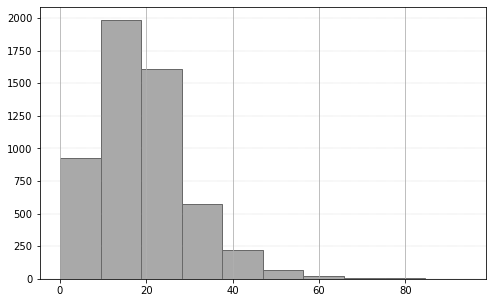

In [44]:
ax = sent_df['word_count'].hist(figsize = (8,5), legend = False, color='darkgrey', edgecolor='dimgray')
ax.yaxis.grid(color='darkgrey', linestyle=':', linewidth=0.4)

***